# Spam Or Ham: SMS Classifier

## Imports

In [1]:
import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [46]:
#Importing all the libraries to be used
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline    
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from matplotlib.colors import ListedColormap
from sklearn.metrics import precision_score, recall_score, ConfusionMatrixDisplay, classification_report, accuracy_score, f1_score
from sklearn import metrics

## Loading data

In [6]:
data = pd.read_csv("../../../assets/data/ml-advanced/model-selection/spam.csv",encoding='ISO-8859-1')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


Dropping the redundent looking collumns (for this project)

In [7]:
to_drop = ["Unnamed: 2","Unnamed: 3","Unnamed: 4"]
data = data.drop(data[to_drop], axis=1)

Renaming the columns because I feel fancy today 

In [8]:
data.rename(columns = {"v1":"Target", "v2":"Text"}, inplace = True)
data.head()

,Target,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


**The dataset consists of 5,574 messages in English. The data is designated as being ham or spam. Dataframe has two columns. The first column is "Target" indicating the class of message as ham or spam and the second "Text" column is the string of text.**

## Data exploration

In [9]:
#Palette
cols= ["#E1F16B", "#E598D8"] 

first of all let us evaluate the target and find out if our data is imbalanced or not

Text(0, 0.5, 'Number of Data points')

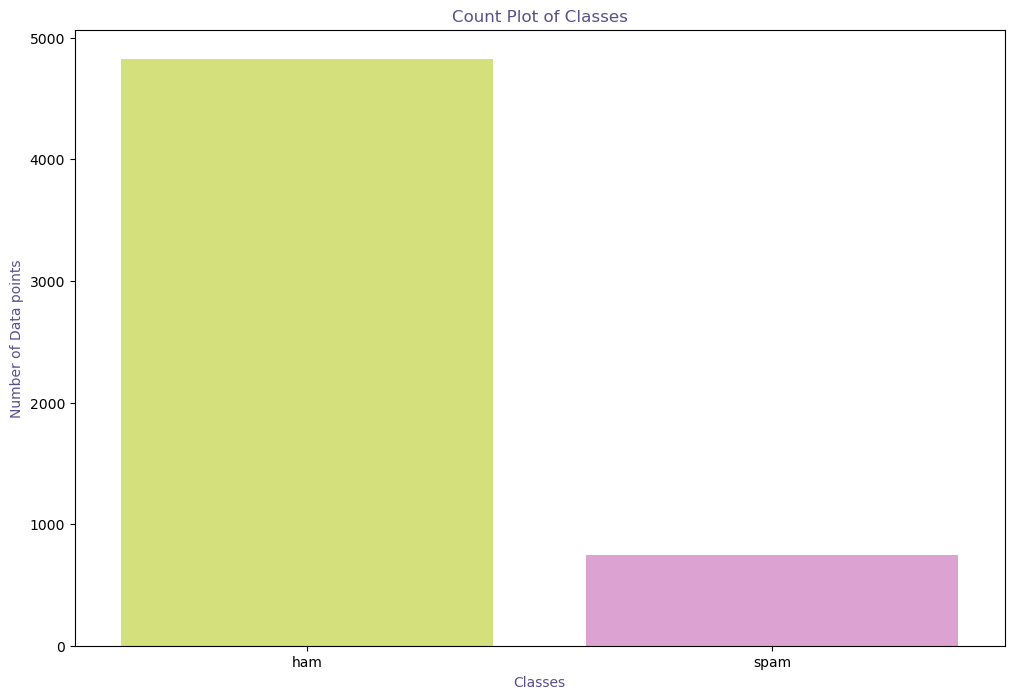

In [10]:
plt.figure(figsize=(12,8))
fg = sns.countplot(x= data["Target"], palette= cols)
fg.set_title("Count Plot of Classes", color="#58508d")
fg.set_xlabel("Classes", color="#58508d")
fg.set_ylabel("Number of Data points", color="#58508d")

**Note:** From the above countplot the data imbalance is quite evident.

### Feature engineering

For the purpose of data exploration, I am creating new features

* No_of_Characters: Number of characters in the text message
* No_of_Words: Number of words in the text message
* No_of_sentence: Number of sentences in the text message

Adding a column of numbers of charachters,words and sentences in each msg

In [12]:
# If you meet lookuperror, you can run following codes to download 'popular' database.
# import nltk
# nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [13]:
data["No_of_Characters"] = data["Text"].apply(len)
data["No_of_Words"]=data.apply(lambda row: nltk.word_tokenize(row["Text"]), axis=1).apply(len)
data["No_of_sentence"]=data.apply(lambda row: nltk.sent_tokenize(row["Text"]), axis=1).apply(len)

data.describe().T

,count,mean,std,min,25%,50%,75%,max
No_of_Characters,5572.0,80.118808,59.690841,2.0,36.0,61.0,121.0,910.0
No_of_Words,5572.0,18.695621,13.742587,1.0,9.0,15.0,27.0,220.0
No_of_sentence,5572.0,1.970747,1.417778,1.0,1.0,1.0,2.0,28.0


PS. At this step, you tokenised the words and sentences and used the length of the same. 
More on Tokenizing later in the notebook.

<Figure size 1200x800 with 0 Axes>

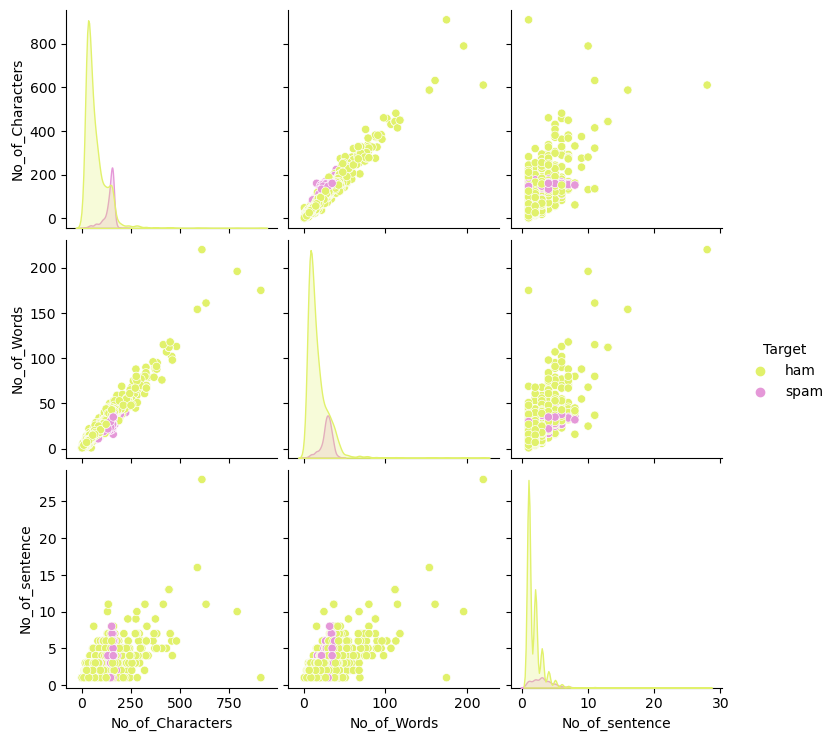

In [14]:
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=data, hue="Target",palette=cols)
plt.show(fg)

**Note:** From the pair plot, we can see a few outliers all in the class ham. This is interesting as we could put a cap over one of these. As they essentially indicate the same thing ie the length of SMS.

Next, I shall be dropping the outliers

### Outlier detection

Dropping the outliers. 

In [15]:
data = data[(data["No_of_Characters"]<350)]
data.shape

(5548, 5)

<Figure size 1200x800 with 0 Axes>

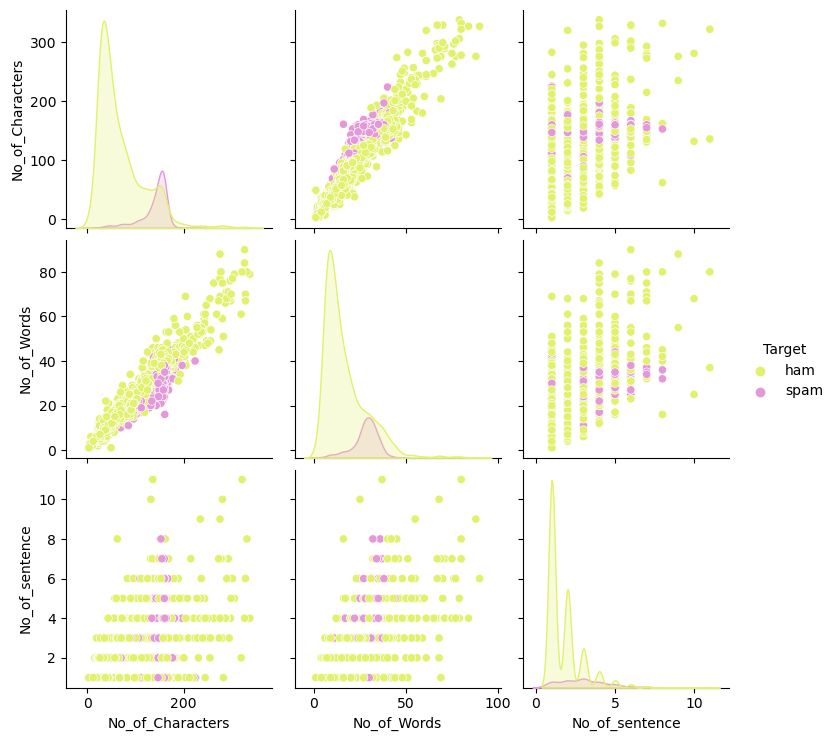

In [16]:
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=data, hue="Target",palette=cols)
plt.show(fg)

Of course, I already knew it would just zoom into, but I still replotted it because look at all those pretty colours! (:

## Data prepreprocessing

### Cleaning text

The data cleaning process NLP is crucial. The computer doesn’t understand the text. for the computer, it is just a cluster of symbols. To further process the data we need to make the data cleaner.

* In the first step we extract only the alphabetic characters by this we are removing punctuation and numbers.
* In the next step, we are converting all the characters into lowercase.
* This text will be then used in further procrssing

Lets have a look at a sample of texts before cleaning

In [17]:
print("\033[1m\u001b[45;1m The First 5 Texts:\033[0m",*data["Text"][:5], sep = "\n")

 The First 5 Texts:
Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Ok lar... Joking wif u oni...
Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
U dun say so early hor... U c already then say...
Nah I don't think he goes to usf, he lives around here though


Defining a function to clean up the text

In [18]:

def Clean(Text):
    sms = re.sub('[^a-zA-Z]', ' ', Text) #Replacing all non-alphabetic characters with a space
    sms = sms.lower() #converting to lowecase
    sms = sms.split()
    sms = ' '.join(sms)
    return sms

data["Clean_Text"] = data["Text"].apply(Clean)

C:\Users\HP\AppData\Local\Temp\ipykernel_16308\333684839.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Clean_Text"] = data["Text"].apply(Clean)


Lets have a look at a sample of texts after cleaning

In [19]:
print("\033[1m\u001b[45;1m The First 5 Texts after cleaning:\033[0m",*data["Clean_Text"][:5], sep = "\n")

 The First 5 Texts after cleaning:
go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat
ok lar joking wif u oni
free entry in a wkly comp to win fa cup final tkts st may text fa to to receive entry question std txt rate t c s apply over s
u dun say so early hor u c already then say
nah i don t think he goes to usf he lives around here though


### Tokenization

**Tokenization** is breaking complex data into smaller units called tokens. It can be done by splitting paragraphs into sentences and sentences into words. I am splitting the Clean_Text into words at this step.

In [20]:
data["Tokenize_Text"]=data.apply(lambda row: nltk.word_tokenize(row["Clean_Text"]), axis=1)

print("\033[1m\u001b[45;1m The First 5 Texts after Tokenizing:\033[0m",*data["Tokenize_Text"][:5], sep = "\n")

 The First 5 Texts after Tokenizing:
['go', 'until', 'jurong', 'point', 'crazy', 'available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'there', 'got', 'amore', 'wat']
['ok', 'lar', 'joking', 'wif', 'u', 'oni']
['free', 'entry', 'in', 'a', 'wkly', 'comp', 'to', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'to', 'to', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 't', 'c', 's', 'apply', 'over', 's']
['u', 'dun', 'say', 'so', 'early', 'hor', 'u', 'c', 'already', 'then', 'say']
['nah', 'i', 'don', 't', 'think', 'he', 'goes', 'to', 'usf', 'he', 'lives', 'around', 'here', 'though']


C:\Users\HP\AppData\Local\Temp\ipykernel_16308\3712914543.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Tokenize_Text"]=data.apply(lambda row: nltk.word_tokenize(row["Clean_Text"]), axis=1)


### Removing stopwords

**Stopwords** are frequently occurring words(such as few, is, an, etc). These words hold meaning in sentence structure, but do not contribute much to language processing in NLP. For the purpose of removing redundancy in our processing, I am removing those. NLTK library has a set of default stopwords that we will be removing.

Removing the stopwords function

In [21]:
def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))
    filtered_text = [word for word in text if word not in stop_words]
    return filtered_text

data["Nostopword_Text"] = data["Tokenize_Text"].apply(remove_stopwords)

print("\033[1m\u001b[45;1m The First 5 Texts after removing the stopwords:\033[0m",*data["Nostopword_Text"][:5], sep = "\n")

 The First 5 Texts after removing the stopwords:
['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'got', 'amore', 'wat']
['ok', 'lar', 'joking', 'wif', 'u', 'oni']
['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'c', 'apply']
['u', 'dun', 'say', 'early', 'hor', 'u', 'c', 'already', 'say']
['nah', 'think', 'goes', 'usf', 'lives', 'around', 'though']


C:\Users\HP\AppData\Local\Temp\ipykernel_16308\3487210476.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Nostopword_Text"] = data["Tokenize_Text"].apply(remove_stopwords)


### Lemmatization

**Stemming** is the process of getting the root form of a word. Stem or root is the part to which inflectional affixes are added. The stem of a word is created by removing the prefix or suffix of a word. It goes back to the etymology of the word. Languages evolve over time. Many different languages branch into each other; for example, English is a derivative of Latin. Thus, stemming a word takes it back to the root word.

**lemmatization** also converts a word to its root form. However, the difference is that lemmatization ensures that the root word belongs to the language one is dealing with, in our case it is English. If we use lemmatization the output would be in English.

In [22]:
lemmatizer = WordNetLemmatizer()
# lemmatize string
def lemmatize_word(text):
    #word_tokens = word_tokenize(text)
    # provide context i.e. part-of-speech
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in text]
    return lemmas

data["Lemmatized_Text"] = data["Nostopword_Text"].apply(lemmatize_word)
print("\033[1m\u001b[45;1m The First 5 Texts after lemitization:\033[0m",*data["Lemmatized_Text"][:5], sep = "\n")

 The First 5 Texts after lemitization:
['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'get', 'amore', 'wat']
['ok', 'lar', 'joke', 'wif', 'u', 'oni']
['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'c', 'apply']
['u', 'dun', 'say', 'early', 'hor', 'u', 'c', 'already', 'say']
['nah', 'think', 'go', 'usf', 'live', 'around', 'though']


C:\Users\HP\AppData\Local\Temp\ipykernel_16308\3990934812.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Lemmatized_Text"] = data["Nostopword_Text"].apply(lemmatize_word)


## Vectorize

**TF-IDF** in NLP stands for Term Frequency – Inverse document frequency. In NLP cleaned data needs to be converted into a numerical format where each word is represented by a matrix. This is also known as word embedding or Word vectorization.

Term Frequency (TF) = (Frequency of a term in the document)/(Total number of terms in documents) Inverse Document Frequency(IDF) = log( (total number of documents)/(number of documents with term t)) I will be using TfidfVectorizer() to vectorize the preprocessed data.

**Steps in the Vectorizing:**

* Creating a corpus of lemmatized text
* Converting the corpus in vector form
* Label Encoding the classes in Target

Note: So far we have been stalking up columns in our data for the purpose of explanation

Creating a corpus of text feature to encode further into vectorized form

In [23]:
corpus= []
for i in data["Lemmatized_Text"]:
    msg = ' '.join([row for row in i])
    corpus.append(msg)
    
corpus[:5]
print("\033[1m\u001b[45;1m The First 5 lines in corpus :\033[0m",*corpus[:5], sep = "\n")

 The First 5 lines in corpus :
go jurong point crazy available bugis n great world la e buffet cine get amore wat
ok lar joke wif u oni
free entry wkly comp win fa cup final tkts st may text fa receive entry question std txt rate c apply
u dun say early hor u c already say
nah think go usf live around though


Changing text data in to numbers. 

In [24]:

tfidf = TfidfVectorizer()
X = tfidf.fit_transform(corpus).toarray()

Let's have a look at our feature 

In [25]:
X.dtype

dtype('float64')

Label encode the Target and use it as y

In [26]:
label_encoder = LabelEncoder()
data["Target"] = label_encoder.fit_transform(data["Target"])

C:\Users\HP\AppData\Local\Temp\ipykernel_16308\275600629.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Target"] = label_encoder.fit_transform(data["Target"])


## Model building

**Steps involved in the Model Building**
* Setting up features and target as X and y
* Splitting the testing and training sets
* Build a pipeline of model for four different classifiers.
  1. Naïve Bayes
  2. RandomForestClassifier
  3. KNeighborsClassifier
  4. Support Vector Machines
* Fit all the models on training data
* Get the cross-validation on the training set for all the models for accuracy

Setting values for labels and feature as y and X(we already did X in vectorizing...)

In [27]:
y = data["Target"] 

Splitting the testing and training sets

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Testing on the following classifiers

In [29]:
classifiers = [MultinomialNB(), 
               RandomForestClassifier(),
               KNeighborsClassifier(), 
               SVC()]
for cls in classifiers:
    cls.fit(X_train, y_train)

Dictionary of pipelines and model types for ease of reference

In [30]:
pipe_dict = {0: "NaiveBayes", 1: "RandomForest", 2: "KNeighbours",3: "SVC"}

Cossvalidation 

In [31]:
for i, model in enumerate(classifiers):
    cv_score = cross_val_score(model, X_train,y_train,scoring="accuracy", cv=10)
    print("%s: %f " % (pipe_dict[i], cv_score.mean()))
#It will takes about 10mins

NaiveBayes: 0.967552 
RandomForest: 0.974087 
KNeighbours: 0.911450 
SVC: 0.974086 


## Evaluating models

**Testing the models on Testset**

* Accuracy Report
* Confusion Matrix

### Model Evaluation


creating lists of varios scores

In [32]:

precision =[]
recall =[]
f1_score = []
trainset_accuracy = []
testset_accuracy = []

for i in classifiers:
    pred_train = i.predict(X_train)
    pred_test = i.predict(X_test)
    prec = metrics.precision_score(y_test, pred_test)
    recal = metrics.recall_score(y_test, pred_test)
    f1_s = metrics.f1_score(y_test, pred_test)
    train_accuracy = model.score(X_train,y_train)
    test_accuracy = model.score(X_test,y_test)


Appending scores

In [33]:
precision.append(prec)
recall.append(recal)
f1_score.append(f1_s)
trainset_accuracy.append(train_accuracy)
testset_accuracy.append(test_accuracy)

Initialise data of lists.

In [34]:
data = {'Precision':precision,
'Recall':recall,
'F1score':f1_score,
'Accuracy on Testset':testset_accuracy,
'Accuracy on Trainset':trainset_accuracy}

Creates pandas DataFrame.

In [35]:
Results = pd.DataFrame(data, index =["NaiveBayes", "RandomForest", "KNeighbours","SVC"])

In [36]:
cmap2 = ListedColormap(["#E2CCFF","#E598D8"])
Results.style.background_gradient(cmap=cmap2)

,Precision,Recall,F1score,Accuracy on Testset,Accuracy on Trainset
NaiveBayes,0.990909,0.801471,0.886179,0.974775,0.997521
RandomForest,0.990909,0.801471,0.886179,0.974775,0.997521
KNeighbours,0.990909,0.801471,0.886179,0.974775,0.997521
SVC,0.990909,0.801471,0.886179,0.974775,0.997521


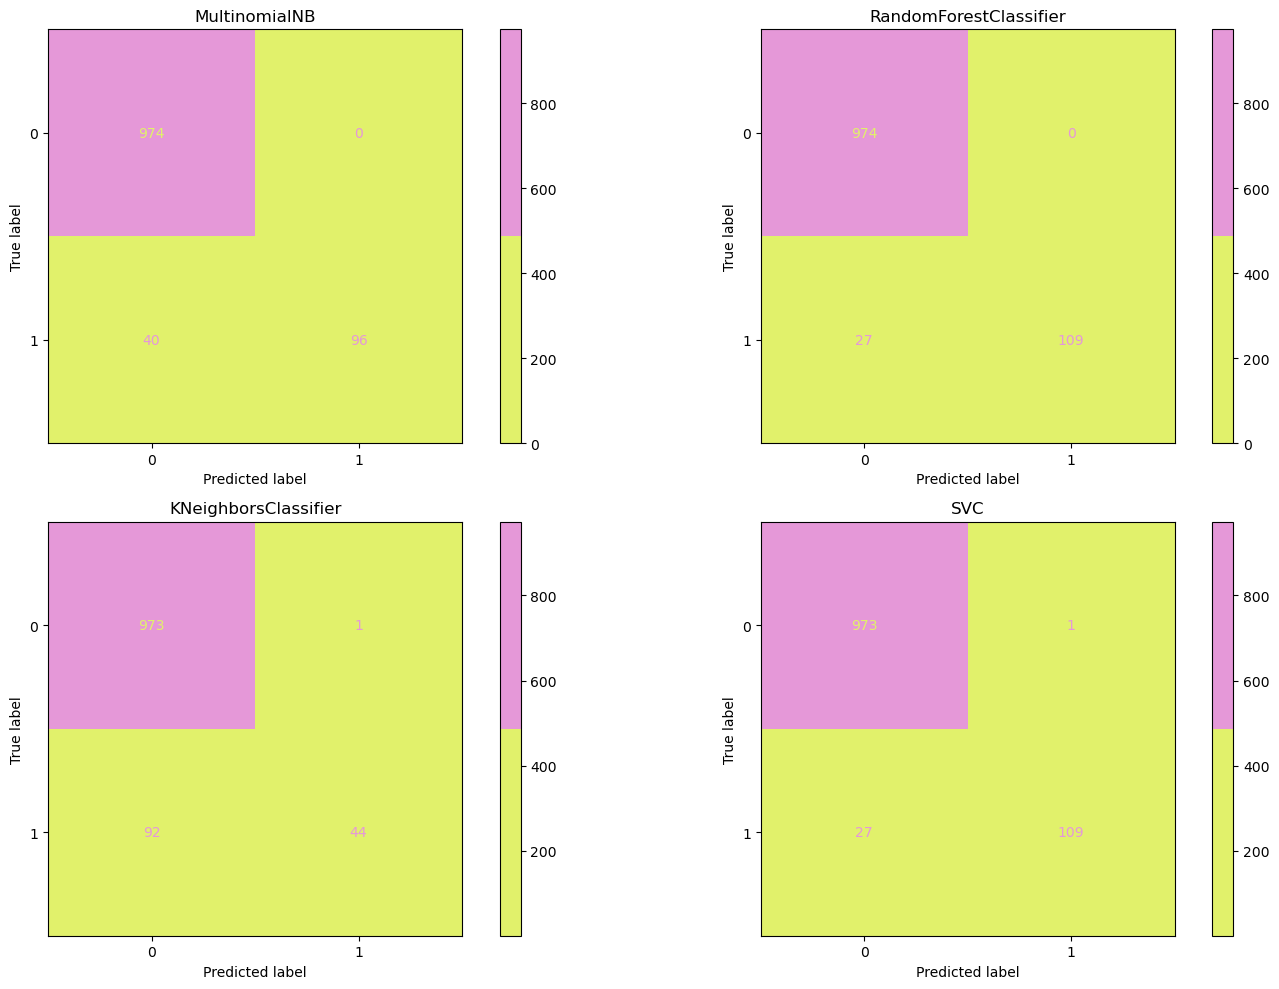

In [57]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

for cls, ax in zip(classifiers, axes.flatten()):
    disp = ConfusionMatrixDisplay.from_estimator(cls, X_test, y_test, ax=ax, cmap=cmap)
    disp.ax_.set_title(type(cls).__name__)

plt.tight_layout()  
plt.show()


## Acknowledgments

Thanks to Karnika Kapoor for creating the open-source project [Spam Or Ham](https://www.kaggle.com/code/karnikakapoor/spam-or-ham-sms-classifier/notebook). It inspires the majority of the content in this chapter.